In [28]:
# if there's problems here, update fastai and torch to latest versions
# pip install 'name' == 'version'
# fastbook needed for bing_image_search
# widgets needed for cleaner
import dotenv
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *

# remember to set dls.device = device and learn.model.to(device)
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# load environment variables
dotenv.load_dotenv()

# use Azure search key
image_key = os.getenv('AZURE_IMAGE_SEARCH_KEY')

if not image_key:
    raise Exception("Set azure key in environment")

# search up images, probably needs a more specific search...
# kaguya_images = search_images_bing(image_key, 'Shinomiya Kaguya')
# ims = kaguya_images.attrgot('contentUrl')

# looking at an image
# dest = 'images/kaguya.jpg'
# download_url(ims[0], dest)
# im = Image.open(dest)
# im.to_thumb(128,128)

characters = ['shinomiya kaguya', 
              'miyuki shirogane', 
              'fujiwara chika', 
              'yu ishigami', 
              'miko iino', 
              'ai hayasaka', 
              'shirogane kei']
path = Path('kaguyasama images')

# make folders for characters
if not path.exists():
    path.mkdir()
    for o in characters:
        dest = path/o 
        dest.mkdir(exist_ok = True) # ok if exists, leave unaltered
        results = search_images_bing(image_key, f"{o}") # search images
        urls = results.attrgot('contentUrl') # get list of urls for images
        download_images(dest, urls=urls) # download images into characters folder

# get image files and unlink failed ones
images = get_image_files(path)
failed = verify_images(fns = images)
failed.map(Path.unlink)

# just checking the number of images which remain after the carnage
# for o in characters:
#     img_list = os.listdir(path/o)
#     print(f'{o}: {len(img_list)}')

# filtering images and then converting all to jpg
for o in characters:
    for root, dirs, files in os.walk(path/o):
        for f in files:
            if not (f.endswith('.jpg') or f.endswith('.png')): # get rid of gifs and other files
                Path.unlink(path/o/f)
            # if f.endswith('.png'): # convert to jpg
            #     im = Image.open(path/o/f)
            #     rgb_im = im.convert('RGB') # set to RGB
            #     rgb_im.save(path/o/f'{f[:-3]}jpg') # change extension to jpg
            #     Path.unlink(path/o/f) # unlink png file


In [32]:
# make DataBlock
# input: images, output: categories (name)
# retrieve input images by calling get_image_files
# do random split with 20% as validation data, make seed random later
# get answer by the name of the folder the image is in (parent_label)
chars = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2),
    get_y = parent_label,
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms()
)

# make DataLoader from DataBlock, pass path data into the dataloader
dls = chars.dataloaders(path)

# learn with resnet18
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,3.193971,1.501573,0.540146,00:42


/Users/albertzhang/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.928240,1.032682,0.328467,00:42
1,1.710027,0.758471,0.277372,01:14
2,1.533025,0.538798,0.189781,01:23
3,1.267235,0.392435,0.131387,01:02
4,1.048437,0.320552,0.109489,00:40
5,0.879188,0.233521,0.065693,00:55
6,0.753516,0.200008,0.058394,00:55
7,0.652030,0.192337,0.058394,00:48
8,0.559680,0.201430,0.065693,01:01
9,0.485669,0.202361,0.065693,00:50


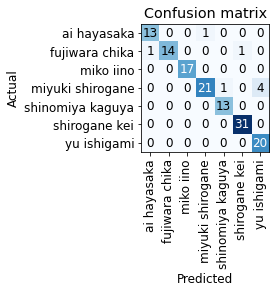

In [33]:
# confusion matrix of results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

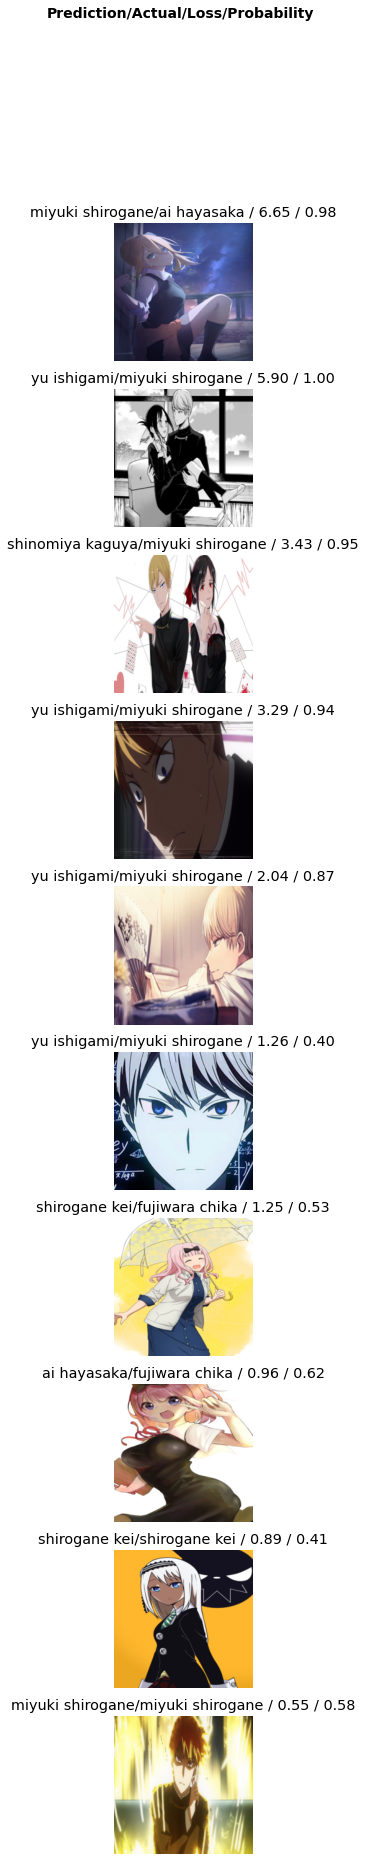

In [34]:
interp.plot_top_losses(10, nrows = 10)

In [26]:
# clean data
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
# delete images from data in cleaner
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [17]:
# switch images to correct category in cleaner
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [35]:
# export model
learn.export('kaguya_model1.pkl')

In [36]:
# checks if the pkl file was created
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('kaguya_model1.pkl')]

In [37]:
learn.predict('images/kaguya.jpg')

('shinomiya kaguya',
 tensor(4),
 tensor([9.0934e-11, 1.6843e-07, 3.4048e-06, 1.5747e-09, 1.0000e+00, 1.0299e-11, 4.2535e-08]))